In [1]:
from typing import List

import joblib
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split

In [2]:
import sklearn

In [3]:
from actlearn.select import kriging_believer, predict_posterior

In [4]:
from rdkit.Chem.MolStandardize import rdMolStandardize

params = rdMolStandardize.CleanupParameters()
params.maxTautomers = 100
params.maxTransforms = 100
te = rdMolStandardize.TautomerEnumerator(params)


def inchi_to_smiles(inchi):
    if not inchi:
        return None
    mol = Chem.MolFromInchi(inchi)
    if not mol:
        return None
    return Chem.MolToSmiles(te.Canonicalize(mol))

In [5]:
def rxn_dfp(rsmi):
    r, _, p = rsmi.split('>')
    rfp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(r), 4, useChirality=True)
    pfp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(p), 4, useChirality=True)
    return np.array(pfp) - np.array(rfp)

In [6]:
results = pd.read_excel('../data/experiment/batch1_raw_data.xlsx')

In [7]:
task_name = 'P1:CAD Yield'

In [8]:
results = results[(results[task_name] != 'no signal') & (results[task_name] != 'INCONCLUSIVE')].dropna(subset=[task_name])

In [9]:
results = results.reset_index(drop=True)

In [10]:
results[task_name] = results[task_name].astype(float)

In [11]:
results['alkyl'] = results['Alkyl bromide InChI'].apply(inchi_to_smiles)
results['aryl'] = results['Aryl Bromide InChI'].apply(inchi_to_smiles)
results['product'] = results['Smiles_product']

In [12]:
results['rsmi'] = results.apply(lambda x: f'{x.alkyl}.{x.aryl}>>{x["product"]}', axis=1)

In [13]:
results[results["smiles_aryl"] == "CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1"]

,Unnamed: 0,P1:IUPAC Name,CAD_product AreaAbs,TWC_product AreaAbs,P1: CAD Actual Mass,P1: UV Actual Mass,P1:Theo Mol,UV Yield,P1:CAD Yield,P1:Theo,...,P1:Product InChi,Alkyl bromide InChI,Aryl Bromide InChI,Smiles_product,Smiles_alkyl,smiles_aryl,alkyl,aryl,product,rsmi
1,1,ethyl 4-(4-(4-(morpholinosulfonyl)benzyl)pheny...,0,0,0,0,32.67 Î¼mol,0,0.0,15.01,...,InChI=1S/C23H25NO7S/c1-2-31-23(27)22(26)16-21(...,InChI=1S/C11H14BrNO3S/c12-9-10-1-3-11(4-2-10)1...,InChI=1S/C12H11BrO4/c1-2-17-12(16)11(15)7-10(1...,CCOC(=O)C(=O)CC(=O)c1ccc(Cc2ccc(S(=O)(=O)N3CCO...,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1,CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1,CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1,CCOC(=O)C(=O)CC(=O)c1ccc(Cc2ccc(S(=O)(=O)N3CCO...,O=S(=O)(c1ccc(CBr)cc1)N1CCOCC1.CCOC(=O)C(=O)CC...
9,9,"(4-(4-(4-ethoxy-3,4-dioxobutanoyl)benzyl)-3-fl...",0,0,0,0,32.67 Î¼mol,0,0.0,12.16,...,InChI=1S/C19H18BFO6/c1-2-27-19(24)18(23)11-17(...,InChI=1S/C7H7BBrFO2/c9-4-5-1-2-6(8(11)12)3-7(5...,InChI=1S/C12H11BrO4/c1-2-17-12(16)11(15)7-10(1...,CCOC(=O)C(=O)CC(=O)c1ccc(Cc2ccc(B(O)O)cc2F)cc1,OB(O)c1ccc(CBr)c(F)c1,CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1,OB(O)c1ccc(CBr)c(F)c1,CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1,CCOC(=O)C(=O)CC(=O)c1ccc(Cc2ccc(B(O)O)cc2F)cc1,OB(O)c1ccc(CBr)c(F)c1.CCOC(=O)C(=O)CC(=O)c1ccc...
17,17,"ethyl 4-(4-(1-(2,4-dichlorophenyl)propyl)pheny...",0,0,0,0,32.67 Î¼mol,0,0.0,13.31,...,InChI=1S/C21H20Cl2O4/c1-3-16(17-10-9-15(22)11-...,InChI=1S/C9H9BrCl2/c1-2-8(10)7-4-3-6(11)5-9(7)...,InChI=1S/C12H11BrO4/c1-2-17-12(16)11(15)7-10(1...,CCOC(=O)C(=O)CC(=O)c1ccc(C(CC)c2ccc(Cl)cc2Cl)cc1,CCC(Br)c1ccc(Cl)cc1Cl,CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1,CCC(Br)c1ccc(Cl)cc1Cl,CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1,CCOC(=O)C(=O)CC(=O)c1ccc(C(CC)c2ccc(Cl)cc2Cl)cc1,CCC(Br)c1ccc(Cl)cc1Cl.CCOC(=O)C(=O)CC(=O)c1ccc...
39,41,"ethyl 4-(4-(3,5-difluorobenzyl)phenyl)-2,4-dio...",0,0,0,0,32.67 Î¼mol,0,0.0,11.31,...,InChI=1S/C19H16F2O4/c1-2-25-19(24)18(23)11-17(...,InChI=1S/C7H5BrF2/c8-4-5-1-6(9)3-7(10)2-5/h1-3...,InChI=1S/C12H11BrO4/c1-2-17-12(16)11(15)7-10(1...,CCOC(=O)C(=O)CC(=O)c1ccc(Cc2cc(F)cc(F)c2)cc1,Fc1cc(F)cc(CBr)c1,CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1,Fc1cc(F)cc(CBr)c1,CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1,CCOC(=O)C(=O)CC(=O)c1ccc(Cc2cc(F)cc(F)c2)cc1,Fc1cc(F)cc(CBr)c1.CCOC(=O)C(=O)CC(=O)c1ccc(Br)...
46,49,ethyl 4-(4-(2-(5-fluoro-2-methoxyphenyl)-2-oxo...,0,0,0,0,32.67 Î¼mol,0,0.0,12.62,...,InChI=1S/C21H19FO6/c1-3-28-21(26)19(25)12-17(2...,InChI=1S/C9H8BrFO2/c1-13-9-3-2-6(11)4-7(9)8(12...,InChI=1S/C12H11BrO4/c1-2-17-12(16)11(15)7-10(1...,CCOC(=O)C(=O)CC(=O)c1ccc(CC(=O)c2cc(F)ccc2OC)cc1,COc1ccc(F)cc1C(=O)CBr,CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1,COc1ccc(F)cc1C(=O)CBr,CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1,CCOC(=O)C(=O)CC(=O)c1ccc(CC(=O)c2cc(F)ccc2OC)cc1,COc1ccc(F)cc1C(=O)CBr.CCOC(=O)C(=O)CC(=O)c1ccc...
60,65,"methyl 5-(4-(4-ethoxy-3,4-dioxobutanoyl)phenyl...",0,0,0,0,32.67 Î¼mol,0,0.0,11.38,...,InChI=1S/C18H20O7/c1-3-25-18(23)16(21)11-15(20...,InChI=1S/C6H9BrO3/c1-10-6(9)3-2-5(8)4-7/h2-4H2...,InChI=1S/C12H11BrO4/c1-2-17-12(16)11(15)7-10(1...,CCOC(=O)C(=O)CC(=O)c1ccc(CC(=O)CCC(=O)OC)cc1,COC(=O)CCC(=O)CBr,CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1,COC(=O)CCC(=O)CBr,CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1,CCOC(=O)C(=O)CC(=O)c1ccc(CC(=O)CCC(=O)OC)cc1,COC(=O)CCC(=O)CBr.CCOC(=O)C(=O)CC(=O)c1ccc(Br)...
68,73,ethyl 4-(4-(benzo[d]oxazol-2-ylmethyl)phenyl)-...,0,0,0,0,32.67 Î¼mol,0,0.0,11.48,...,InChI=1S/C20H17NO5/c1-2-25-20(24)17(23)12-16(2...,InChI=1S/C8H6BrNO/c9-5-8-10-6-3-1-2-4-7(6)11-8...,InChI=1S/C12H11BrO4/c1-2-17-12(16)11(15)7-10(1...,CCOC(=O)C(=O)CC(=O)c1ccc(Cc2nc3ccccc3o2)cc1,BrCc1nc2ccccc2o1,CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1,BrCc1nc2ccccc2o1,CCOC(=O)C(=O)CC(=O)c1ccc(Br)cc1,CCOC(=O)C(=O)CC(=O)c1ccc(Cc2nc3ccccc3o2)cc1,BrCc1nc2ccccc2o1.CCOC(=O)C(=O)CC(=O)c1ccc(Br)c...
76,81,"(4-(4-(4-ethoxy-3,4-dioxobutanoyl)phenethoxy)p...",0,0,0,0,32.67 Î¼mol,0,0.0,12.55,...,InChI=1S/C20H21BO7/c1-2-27-20(24)19(23)13-18(2...,InChI=1S/C8H10BBrO3/c10-5-6-13-8-3-1-7(2-4-8)9...,InChI=1S/C12H11BrO4/c1-2-17-12(16)11(15)7-10(1...,CCOC(=O)C(=O)CC(=O)c1ccc(CCOc2c

In [17]:
alkyl = pd.read_csv('../data/BrBr_dft_selectfeatures_alkylBr.csv')
aryl = pd.read_csv('../data/BrBr_dft_selectfeatures_arylBr.csv')

In [18]:
alkyl['smiles'] = alkyl['smiles'].apply(lambda x: Chem.CanonSmiles(x, False))
aryl['core_smiles'] = aryl['core_smiles'].apply(lambda x: Chem.CanonSmiles(x, False))

In [19]:
alkyl = alkyl.groupby('smiles').mean(numeric_only=True)
aryl = aryl.groupby('core_smiles').mean(numeric_only=True)

In [20]:
dfp = np.vstack(joblib.Parallel(n_jobs=32, verbose=1)(
    joblib.delayed(rxn_dfp)(rsmi) for rsmi in results['rsmi']
))

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  83 out of  83 | elapsed:    8.8s finished


In [21]:
core_f = aryl.loc[results['aryl']].values
bb_f = alkyl.loc[results['alkyl']].values

In [22]:
f = np.hstack([dfp, core_f, bb_f])

In [23]:
f_cols = [f'f_{idx}' for idx in range(f.shape[1])]

In [24]:
results.loc[:, f_cols] = f

In [25]:
domain = pd.read_csv('../data/brbr_reaction_domain_batch1.csv')

In [26]:
domain['smiles_alkyl'] = domain['smiles_alkyl'].apply(lambda x: Chem.CanonSmiles(x, False))
domain['smiles_aryl'] = domain['smiles_aryl'].apply(lambda x: Chem.CanonSmiles(x, False))

In [27]:
domain_dfp = np.vstack(joblib.Parallel(n_jobs=32, verbose=1)(
    joblib.delayed(rxn_dfp)(rsmi) for rsmi in domain['reaction_smarts']
))

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 224 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 1224 tasks      | elapsed:    1.8s
[Parallel(n_jobs=32)]: Done 2624 tasks      | elapsed:    3.6s
[Parallel(n_jobs=32)]: Done 4424 tasks      | elapsed:    5.8s
[Parallel(n_jobs=32)]: Done 6624 tasks      | elapsed:    8.7s
[Parallel(n_jobs=32)]: Done 9224 tasks      | elapsed:   11.9s
[Parallel(n_jobs=32)]: Done 12224 tasks      | elapsed:   15.8s
[Parallel(n_jobs=32)]: Done 15624 tasks      | elapsed:   20.4s
[Parallel(n_jobs=32)]: Done 19424 tasks      | elapsed:   25.4s
[Parallel(n_jobs=32)]: Done 22208 out of 22208 | elapsed:   28.8s finished


In [28]:
domain_core_f = aryl.loc[domain['smiles_aryl']].values
domain_bb_f = alkyl.loc[domain['smiles_alkyl']].values

In [29]:
domain_f = np.hstack([domain_dfp, domain_core_f, domain_bb_f])

In [30]:
domain.loc[:, f_cols] = domain_f

In [31]:
domain['product'] = domain['smiles'].apply(lambda x: Chem.CanonSmiles(x, False))

In [32]:
domain = domain[~domain['smiles_alkyl'].isin(results['alkyl'])]

In [33]:
test_set = pd.read_csv('../data/syntech_lib_br_testset.csv')

In [34]:
test_set['smiles'] = test_set['smiles'].apply(lambda x: Chem.CanonSmiles(x, False))

In [35]:
domain = domain[~domain['smiles_alkyl'].isin(test_set['smiles'])]

In [36]:
experiments = kriging_believer(
    domain=domain,
    results=results,
    x_cols=f_cols,
    batch_size=12,
    id_column='product',
    target_column=task_name,
    bb_smiles_column='smiles_alkyl',
    output_dir='iterations/batch_1'
)

100%|██████████| 12/12 [01:06<00:00,  5.53s/it]


In [37]:
from rdkit.Chem import PandasTools

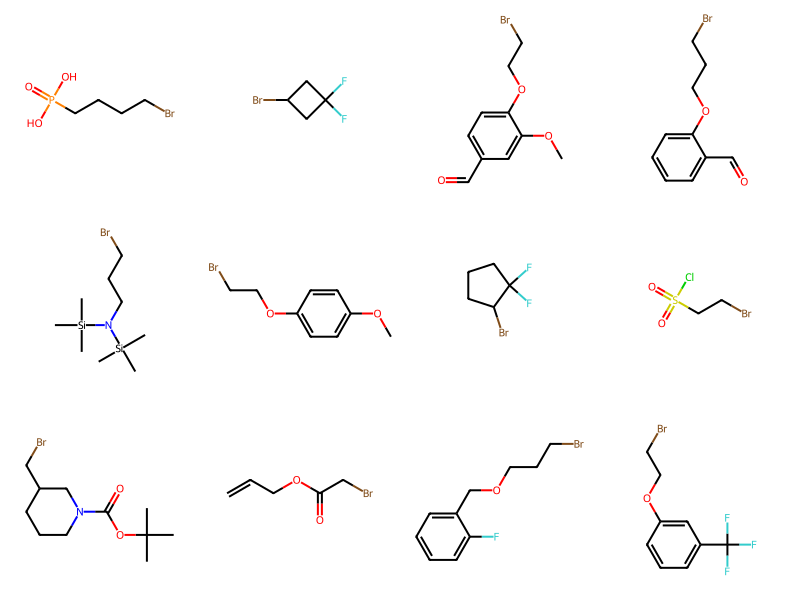

In [38]:
df = PandasTools.LoadSDF('iterations/batch_1/selections.sdf')
Chem.Draw.MolsToGridImage(df["ROMol"], subImgSize=(200,200), molsPerRow=4)

Failed to patch pandas - unable to change molecule rendering


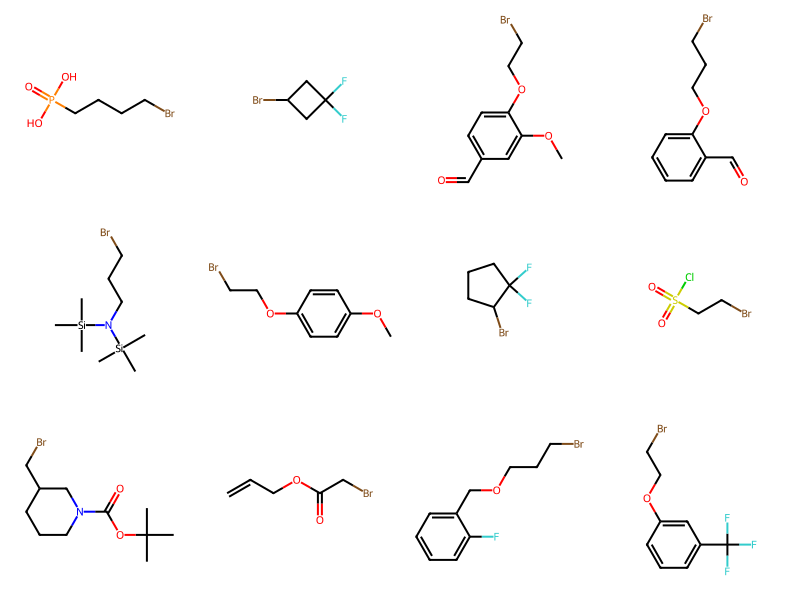

In [43]:
df = PandasTools.LoadSDF('iterations/batch_1/selections.sdf')
Chem.Draw.MolsToGridImage(df["ROMol"], subImgSize=(200,200), molsPerRow=4)

In [ ]:
import tarfile

    
with tarfile.open(f'iterations/batch_1.tar.gz', "w:gz") as tar:
    tar.add("iterations/batch_1/")